# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล

ใช้ชุดข้อมูล Dataset พันธุ์หมาแมว [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) 

In [3]:
path = untar_data(URLs.PETS)
path_images = path/'images'
filenames = get_image_files(path_images)

# 3. เตรียมข้อมูล

เพื่อความสะดวก เราจะประกาศฟังก์ชัน แล้วไปเรียกสร้างก่อน fit ด้วย Dropout แต่ละแบบ

เราจะไม่ทำ Data Augmentation จะได้เปรียบเทียบให้เห็นได้ชัด ๆ

In [4]:
batchsize = 32
epoch = 8
lr = slice(3e-6, 1e-2)
np.random.seed(55)
regex_pattern = r'/([^/]+)_\d+.jpg$'
transform = zoom_crop(scale=(1.0,1.0), do_rand=False)

def get_databunch():
    return ImageDataBunch.from_name_re(path_images, filenames, 
                                   regex_pattern, ds_tfms=transform, 
                                   size=224, bs=batchsize).normalize(imagenet_stats)

# 4. สร้างโมเดล

เพื่อความสะดวก เราจะประกาศฟังก์ชัน แล้วไปเรียกสร้างก่อน fit ด้วย Dropout แต่ละแบบ

* เคสนี้เราจะใช้โมเดล models.resnet34

In [5]:
def get_learner(databunch):
    learner = cnn_learner(databunch, models.resnet34, 
                      ps=ps, wd=1e-1, 
                      metrics=accuracy, callback_fns=ShowGraph)
    learner.unfreeze()
    return learner

# 5. เริ่มต้นเทรนโมเดล

ปกติ ps จะมีค่า Default เท่ากับ 0.5 เราจะลองเทรนด้วย ps ต่ำมาก ไป สูงมาก เปรียบเทียบกับ [Image Classification ep.3](https://www.bualabs.com/archives/509/mnist-fastai-resnet18-image-classification-ep-3/) ดูว่าจะเป็นอย่างไร

## ลองเทรนโดยไม่ Droput เลย ด้วย ps = 0.0

epoch,train_loss,valid_loss,accuracy,time
0,0.483516,0.446440,0.868065,00:46
1,0.517633,0.549559,0.845061,00:44
2,0.396994,0.550972,0.860622,00:43
3,0.253108,0.642036,0.851827,00:44
4,0.130108,0.410855,0.891069,00:44
5,0.053730,0.379663,0.905954,00:44
6,0.015057,0.353431,0.920162,00:44
7,0.005827,0.355878,0.918809,00:44


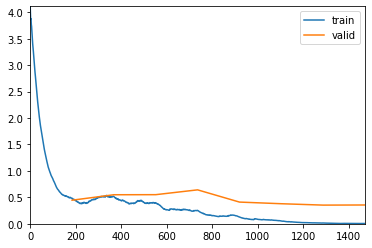

In [6]:
ps = 0.0

learner = get_learner(get_databunch())
learner.fit_one_cycle(epoch, max_lr=lr)

## ลองเทรนด้วย Droput น้อย ๆ ด้วย ps = 0.25

epoch,train_loss,valid_loss,accuracy,time
0,0.539468,0.458809,0.853857,00:44
1,0.588430,0.535811,0.839648,00:44
2,0.394254,0.599292,0.827470,00:44
3,0.261712,0.444621,0.876184,00:44
4,0.124739,0.457326,0.882273,00:44
5,0.063439,0.338250,0.910690,00:44
6,0.014444,0.279363,0.923545,00:44
7,0.006212,0.280957,0.928958,00:44


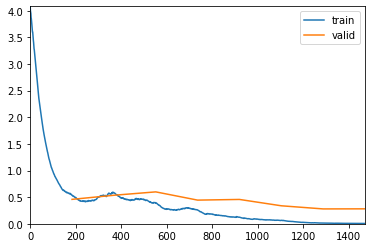

In [7]:
ps = 0.25

learner = get_learner(get_databunch())
learner.fit_one_cycle(epoch, max_lr=lr)

## ลองเทรนด้วย Droput กลาง ๆ ด้วย ps = 0.5 (ค่า Default)

epoch,train_loss,valid_loss,accuracy,time
0,0.666519,0.314958,0.905277,00:44
1,0.619887,0.574725,0.828823,00:44
2,0.546697,0.458018,0.875507,00:44
3,0.296509,0.444978,0.894452,00:45
4,0.121188,0.348354,0.895805,00:44
5,0.080168,0.336187,0.910690,00:44
6,0.023657,0.279675,0.925575,00:44
7,0.010611,0.285148,0.928281,00:44


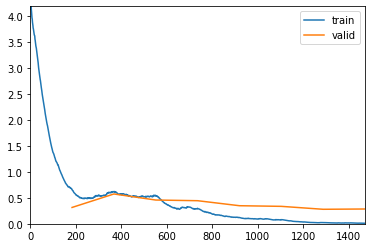

In [8]:
ps = 0.5

learner = get_learner(get_databunch())
learner.fit_one_cycle(epoch, max_lr=lr)

## ลองเทรนด้วย Droput มาก ๆ ด้วย ps = 0.75

epoch,train_loss,valid_loss,accuracy,time
0,1.076733,0.404477,0.866712,00:44
1,0.791470,0.647821,0.827470,00:45
2,0.601026,0.629499,0.845737,00:44
3,0.438453,0.517568,0.859946,00:44
4,0.258529,0.438515,0.893775,00:45
5,0.077801,0.384949,0.902571,00:44
6,0.041624,0.362663,0.906631,00:44
7,0.021978,0.348967,0.910690,00:44


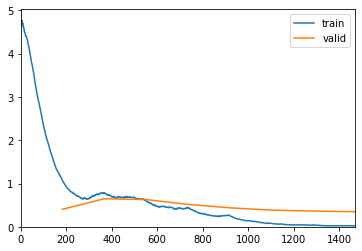

In [9]:
ps = 0.75

learner = get_learner(get_databunch())
learner.fit_one_cycle(epoch, max_lr=lr)

## ลองเทรนด้วย Droput ให้หมดเลย ด้วย ps = 1.0

epoch,train_loss,valid_loss,accuracy,time
0,3.611926,3.876554,0.012179,00:43
1,3.613964,3.792077,0.012179,00:43
2,3.614809,3.715607,0.015562,00:43
3,3.613930,3.678996,0.013532,00:43
4,3.614936,3.661735,0.014885,00:44
5,3.613841,3.653584,0.018268,00:43
6,3.611492,3.649886,0.016238,00:43
7,3.610724,3.649593,0.020298,00:43


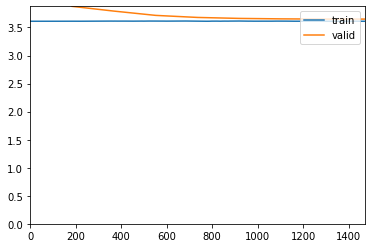

In [10]:
ps = 1.0

learner = get_learner(get_databunch())
learner.fit_one_cycle(epoch, max_lr=lr)

# 6. สรุป

เปรียบเทียบ การเทรนแต่ละ Dropout (ps) ในตารางดังนี้

|         ps | Time  | Accuracy | Valid Loss |
|-----------:|-------|---------:|-----------:|
|       0.00 | 05:55 |    91.9% |      0.355 |
|       0.25 | 05:52 |    92.9% |      0.280 |
|       0.50 | 05:53 |    92.8% |      0.285 |
|       0.75 | 05:54 |    91.0% |      0.349 |
|       1.00 | 05:45 |     2.0% |      3.649 |

# หมายเหตุ

* อันนี้เป็นการทดสอบแบบคร่าว ๆ ให้พอเห็นภาพ มีตัวแปรอีกหลายอย่าง
* ใน Framework มีการใช้อีกหลายอัลกอริทึมโดย Default อาจทำให้ผลลัพธ์แตกต่างกันไป
* แต่ละ learner มีการ Initial Weight ที่แตกต่างกัน
* ps จะถูกใช้เป็น ค่า Probability ของ Dropout สำหรับ Layer สุดท้าย แต่ Layer ก่อนหน้านั้นจะใช้ ps/2